# Spectral Overlap File (SOF) calculation 
The spectral and total absorption rates (SAR & TAR) are calculated and stored in SOF.
The Total Absorption Rate ($\gamma$) is also stored in the *tar_table_df* dataframe for posterior analysis. The calculation is performed for the combination of pigments, stars and atmospheres stored in their respective folders under `exophot/input/`. 

### Input:
- spectral_overlap_functions library (imported as *sof*) located on `exophot/codes/spectral_overlap_functions.py`
- pigment: files with extinction coefficient spectrum located at `exophot/input/pigments/`
- atmospheres: files with atmosphere transmitance spectrum located at `exophot/input/atmosphere/`
- SEDs: files with spectral flux density spectrum located at `exophot/input/stellar/`
- df_exo: auxiliary file containing solar radii (Rs) and habitable zone (hz) boundaries (inner, mid, outer) for different solar spectral types located at `exophot/input/exosys_params.csv`

### Output:
- tar_table_df: pandas dataframe with Total Absorption Rate (TAR, $\gamma$) results
- Spectral Overlap Files (SOF) under `exophot/output/SOF` containing:
    * Date
    * SED file
    * atmosphere file
    * photopigment file
    * Stellar radius (Rs in km)
    * Exoplanet orbit semi-major axis (sma in km)
    * Total absorption rate  (gamma_t in s-1)
    * B band absorption rate (gamma_B in s-1)
    * Q band absorption rate (gamma_Q in s-1) 
    * B-Q bands cut-off (in nm)
    * photosynthetic photon flux density (ppfd in micromol photon m-2 s-1)
    * Total Stellar Irradiance (S in W m-2):
            * Col 1: Wavelength (wl in Angstrom) 
            * Col 2: Spectral Flux Density (F_l in J cm-2 s-1 A-1) 
            * Col 3: Atmosphere transmitance (T, no units)
            * Col 4: Pigment absorption cross section (sigma_abs in cm-2)
            * Col 5: Spectral Absorption Rate (Gamma_lambda in A-1 s-1)



## 1) Load libraries and functions to compute spectral absorption rate

Load libraries and functions

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from os import walk
from pathlib import Path

#import spectral_overlap_functions as sof # .py file with functions needed to quantify spectral overlap

In [2]:
import sys
sys.path.append("..")

from codes import spectral_overlap_functions as sof # .py file with functions needed to quantify spectral overlap


Define functions that will be handy

In [3]:
def plot_spectra(wl, sigma_int, spec_abs_rate_int, abs_rate, ax):
    """Helper function to plot absorption cross section
    and spectral absorption rate"""
    
    ax.plot(wl, sigma_int)
    ax1=ax.twinx()
    
    ax1.plot(wl, spec_abs_rate_int, c = 'tab:orange')
    ax.set_ylim(0,None)
    ax.autoscale(enable=True, axis='x', tight=True)
    ax1.set_ylim(0,None)
    ax1.autoscale(enable=True, axis='x', tight=True)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1), useOffset=False)
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1), useOffset=False)
    
    ax.set_title(pigm[:-4] + ' in \n' + atmos[:-4])
    ax.set_ylabel('Absorption \n Cross section (cm$^{-2}$)',color = 'tab:blue')
    ax1.set_ylabel('Spectral Absorption \n Rate ($\AA^{-1}$ s$^{-1}$)',color = 'tab:orange')
    ax.set_xlabel('Wavelength ($\AA$)')    
    
    abs_str = '{:.2f}'.format(abs_rate)
    ax.text(0.01, 0.85, 'Abs. Rate ($\gamma_t$):\n ' + abs_str + ' s$^{-1}$', horizontalalignment='left', 
         verticalalignment='center',color= 'gray', transform=ax.transAxes)


## 2) Example of usage for a single combination of star, atmosphere and pigment
The Spectral Absorption Rate is calculated and plotted for the selected system. Results are saved to SOF (Spectral Overlap File) at exophot/output/SOF.

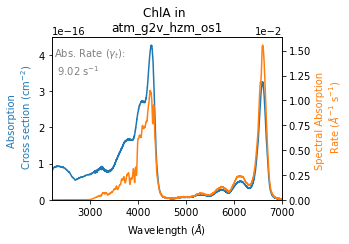

In [4]:
# Exoplanet system parameters (Sun/Earth pair)
Rs = 696340 # stellar radius in km
sma = 1.496e8 # Exoplanet orbital semi-major axis in km

# specify file names
atmos = 'atm_g2v_hzm_os1.txt'
star = 'SED_g2v.txt'
pigm = 'ChlA.txt'

# folders containing input files
folders = ['../input/stellar/', '../input/atmosphere/', '../input/pigments/']

# read files to retrieve spectra
flux, trans, epsilon = sof.read_files(folders[0] + star, folders[1] + atmos, folders[2] + pigm)

# compute spectral and total absorption rates and ppfd
spectra, rates = sof.spectral_overlap(flux, trans, epsilon, Rs, sma)

# load auxiliary file containing solar radii (Rs) and habitable zone (hz) boundaries (inner, mid, outer) for different solar spectral types
df_exo = pd.read_csv('../input/exosys_params.csv', comment = '#')


# the stellar model file and the exoplanet system parameters (Rs and sma) depend on the atmosphere file
Stype, Pigment, Atmosphere, Rs, sma, S = sof.get_exo_params(atmos, df_exo)

# save results to SOF (Spectral Overlap File) at exophot/output/SOF
sof.save_results(star, atmos, pigm, Rs, sma, S, spectra, rates)

# plot spectra
wl, F, T, sigma, rho_l = np.hsplit(spectra, spectra.shape[1])

fig, ax = plt.subplots(1,1,figsize=(5,3.5))
plot_spectra(wl, sigma, rho_l, rates[0], ax)

plt.tight_layout()
#plt.savefig('../output/figures/spectral_overlap_plot.jpg', dpi = 150)
plt.show()   


## 3) Calculation of Spectral & Total Absorption Rates (SAR & TAR) for combinations of stars, atmospheres and pigments
The Spectral Absorption Rate is calculated for the combinations of systems provided in the input folders. Results are saved to SOF (Spectral Overlap File) at exophot/output/SOF.

Retrieve names of files with star flux, atmosphere transmitance and pigment absorption spectra

In [5]:
# --------------------------------------------------------------------
# Lists of atmospheres, pigments and stellar models files
# --------------------------------------------------------------------

# folders containing input files
folders = ['../input/stellar/', '../input/atmosphere/', '../input/pigments/']

# Read and store the names of all files
_, _, names_star = next(walk(folders[0]))
_, _, names_atmos = next(walk(folders[1]))
_, _, names_pigm = next(walk(folders[2]))

# check file names
names_atmos, names_star, names_pigm

(['atm_a5v_hzm_os1.txt',
  'atm_a5v_hzm_os2.txt',
  'atm_a5v_hzm_os3.txt',
  'atm_a5v_hzm_os4.txt',
  'atm_g2v_hzi_os1.txt',
  'atm_g2v_hzi_os2.txt',
  'atm_g2v_hzi_os3.txt',
  'atm_g2v_hzi_os4.txt',
  'atm_g2v_hzm_os1.txt',
  'atm_g2v_hzm_os2.txt',
  'atm_g2v_hzm_os3.txt',
  'atm_g2v_hzm_os4.txt',
  'atm_g2v_hzo_os1.txt',
  'atm_g2v_hzo_os2.txt',
  'atm_g2v_hzo_os3.txt',
  'atm_g2v_hzo_os4.txt',
  'atm_m8v_hzm_os1.txt',
  'atm_m8v_hzm_os2.txt',
  'atm_m8v_hzm_os3.txt',
  'atm_m8v_hzm_os4.txt'],
 ['SED_a5v.txt', 'SED_g2v.txt', 'SED_m8v.txt'],
 ['BChlA.txt', 'BChlB.txt', 'ChlA.txt', 'ChlB.txt', 'Phot0-Zn.txt'])

Retrieve and load auxiliary file containing solar radii (Rs) and habitable zone (hz) boundaries (inner, mid, outer) for different solar spectral types.


In [6]:
# load auxiliary file containing solar radii (Rs) and habitable zone (hz) boundaries (inner, mid, outer) for different solar spectral types
df_exo = pd.read_csv('../input/exosys_params.csv', comment = '#')
df_exo

,ST,Teff,Rs,Ls,hzi,hzm,hzo,S_hzi,S_hzm,S_hzo
0,a5v,8250.0,1.700,12.083850,2.503394,3.464906,3.911554,2624.57,1370.042,1075.024
1,f5v,6500.0,1.300,2.722901,1.188345,1.644768,1.856789,2624.57,1370.042,1075.024
2,g2v,5750.0,1.000,0.986650,0.715333,0.990080,1.117707,2624.57,1370.042,1075.024
3,k5v,4250.0,0.720,0.152655,0.281373,0.389444,0.439646,2624.57,1370.042,1075.024
4,m8v,2500.0,0.121,0.000516,0.016362,0.022646,0.025566,2624.57,1370.042,1075.024


## Files (SOF) with the Spectral Absorption Rates (SAR)
SAR results are saved to SOF (Spectral Overlap File) at `exophot/output/SOF`. Each SOF contains:
-   Date
-   SED file
-   atmosphere file
-   photopigment file
-   Stellar radius (Rs in km)
-   Exoplanet orbit semi-major axis (sma in km)
-   Total absorption rate  (gamma_t in s-1)
-   B band absorption rate (gamma_B in s-1)
-   Q band absorption rate (gamma_Q in s-1) 
-   B-Q bands cut-off (in nm)
-   photosynthetic photon flux density (ppfd in micromol photon m-2 s-1)
-   Total Stellar Irradiance (S in W m-2):
            -   Col 1: Wavelength (wl in Angstrom) 
            -   Col 2: Spectral Flux Density (F_l in J cm-2 s-1 A-1) 
            -   Col 3: Atmosphere transmitance (T, no units)
            -   Col 4: Pigment absorption cross section (sigma_abs in cm-2)
            -   Col 5: Spectral Absorption Rate (Gamma_lambda in A-1 s-1)


## Table withTotal Absorption Rate (TAR) results
This table contains resulting absortion rates ($\gamma$), photosynthetic photon flux density (ppfd) and stellar irradiance (S) to be presented in the ExoPhot I publication for the middle habitable zone of a combination of stars, atmospheres and pigments. 
Similar tables (below) will be included in the Supplementary Information document for the inner and outer regions of the habitable zone.

-   $\gamma_t$:             total absorption rate [s-1]
-   $\gamma_B$:             absorption rate at B band [s-1]
-   $\gamma_Q$:             absorption rate at Q band [s-1]
-   ppfd:                photosynthetic photon flux density [micromol photon m-2 s-1]
-   S:                  Total Stellar Irradiance (in W m-2)

In [7]:
#Set a pandas dataframe to alocate the Total Absorption Rate (TAR) table.
#First row is set with empty values
tar_table_df = pd.DataFrame({
    "Star":"Sun",
    "HZ":"middle",
    "Atmosphere":"os1",
    "Pigment":"ChlA",
    "gamma_t": pd.Series(1, index=list(range(1)), dtype="float32"),
    "gamma_B":0.0,
    "gamma_Q":0.0,
    "ppfd":0.0,
    "S":0.0})


# iterate through atmosphere and pigment file names:
r1 = range(len(names_atmos))
r2 = range(len(names_pigm))

iterator = 0
for ii, jj in itertools.product(r1,r2): # this is a nested loop
    # select atmosphere and pigment file names
    atmos = names_atmos[ii]
    pigm =  names_pigm[jj]
 
    iterator = iterator + 1
    # the stellar model file and the exoplanet system parameters (Rs and sma) depend on the atmosphere file
    Stype, region_hz, atmosphere, Rs, sma, S = sof.get_exo_params(atmos, df_exo)
    star = 'SED_' + Stype + '.txt' 
      
    
    tar_table_df.at[iterator,"Star"] = Stype
    tar_table_df.at[iterator,"Atmosphere"] = atmosphere
    tar_table_df.at[iterator,"Pigment"] = pigm[0:-4]
    tar_table_df.at[iterator,"HZ"] = region_hz    
    tar_table_df.at[iterator,"S"] = S
    
    # read files to retrieve spectra
    flux, trans, epsilon = sof.read_files(folders[0] + star, folders[1] + atmos, folders[2] + pigm)

    # compute spectral and total absorption rates and ppfd
    spectra, rates = sof.spectral_overlap(flux, trans, epsilon, Rs, sma)

    # save results to SOF at 'exophot/output/SOF'
    sof.save_results(star, atmos, pigm, Rs, sma, S, spectra, rates)

    tar_table_df.at[iterator,"gamma_t"] = rates[0]
    tar_table_df.at[iterator,"gamma_B"] = rates[1]
    tar_table_df.at[iterator,"gamma_Q"] = rates[2]
    tar_table_df.at[iterator,"ppfd"] = rates[3]

#Drop firs row with empty values
if tar_table_df.iat[0,0] == "Sun":
    tar_table_df=tar_table_df.drop([0])

 

## Store results in pandas dataframe

Store this dataframe in *tar_table_df* for posterior analysis.

In [8]:
# store this dataframe for posterior analysis
%store tar_table_df


# Retrieve stored dataframe
#%store -r tar_table_df
   

Stored 'tar_table_df' (DataFrame)


In [9]:
tar_table_df

,Star,HZ,Atmosphere,Pigment,gamma_t,gamma_B,gamma_Q,ppfd,S
1,a5v,hzm,os1,BChlA,11.421699,4.775585,6.646113,2400.479453,1370.042
2,a5v,hzm,os1,BChlB,15.682876,8.915904,6.766972,2400.479453,1370.042
3,a5v,hzm,os1,ChlA,13.535886,9.790268,3.745617,2400.479453,1370.042
4,a5v,hzm,os1,ChlB,16.235056,12.963893,3.271163,2400.479453,1370.042
5,a5v,hzm,os1,Phot0-Zn,6.370141,1.908224,4.461917,2400.479453,1370.042
...,...,...,...,...,...,...,...,...,...
96,m8v,hzm,os4,BChlA,1.028818,0.001721,1.027097,17.983625,1370.042
97,m8v,hzm,os4,BChlB,1.822631,0.004198,1.818433,17.983625,1370.042
98,m8v,hzm,os4,ChlA,0.075462,0.002624,0.072838,17.983625,1370.042
99,m8v,hzm,os4,ChlB,0.065527,0.016697,0.048829,17.983625,1370.042
